## Run GGL pipeline examples

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io.fits as fits
import h5py as h5
import setup
import ggl

plt.rcParams.update({
    'font.family':'serif',
    'font.size':12.0,
    'axes.labelsize': 'x-large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'axes.titlesize':'x-large',
    'legend.fontsize': 'large',
    'xtick.direction':'in',
    'ytick.direction':'in',
    'lines.linewidth':2,
    'patch.linewidth':2,
    'lines.color':'black',
    'mathtext.fontset' : 'stix',
    'figure.titlesize': 'xx-large',
    'figure.facecolor':  (1.0, 1.0, 1.0, 1.0),
    'axes.facecolor':    (1.0, 1.0, 1.0, 1.0), 
    'savefig.facecolor': (1.0, 1.0, 1.0, 1.0)})

colors = ['dodgerblue', 'darkgreen', 'darkorange', 'darkred', 'violet', 'slateblue']

zl_bins = [[0.20, 0.40], 
            [0.40, 0.55], 
            [0.55, 0.70], 
            [0.70, 0.85],
            [0.85, 0.95],
            [0.95, 1.05]]

In [55]:
def plot_gammat(theta, gammat, gammat_err, l_zbins, s_zbins):
    
    fig = plt.figure(figsize=(6, 4))
    
    plt.errorbar(theta, gammat, gammat_err, 
                ls='', marker='.', color=colors[s_zbin], label=f'source bin {s_zbin+1}')
            
    plt.title(f'lens bin {l_zbin+1}')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r'$\theta$ [arcmin]')
    plt.ylabel(r'$\gamma_t (\theta)$')
    plt.legend()

    plt.tight_layout()
    fig.patch.set_alpha(1.0)
    #plt.savefig('gammat.png', dpi=150, bbox_inches='tight')
    #plt.show()

### Run it for single lens x source bins

e.g. for MagLim bin 1, Metacal bin 4

In [38]:
mastercat = '/global/cfs/cdirs/des/www/y3_cats/Y3_mastercat_02_05_21.h5'
randoms_y3 = '/global/cfs/cdirs/des/y6-gglensing/Y3_maglim_randoms.fits'

l_zbin = 0
zl_lims = zl_bins[l_zbin]
s_zbin = 3
print('Lens bin {:d}, source bin {:d}'.format(l_zbin, s_zbin))
            
# load lenses maglim Y3        
ra_l, dec_l, w_l = setup.load_lens_Y3_maglim(mastercat, zl_lims)
print('Num lenses = {:d}'.format(len(ra_l)))

# load sources metacal Y3
ra_s, dec_s, e1, e2, R, w_s = setup.load_source_metacal(mastercat, s_zbin)
print('Num sources = {:d}'.format(len(ra_s)))
print('Average e1 = {:f}'.format(np.average(e1, weights=w_s)))
print('Average e2 = {:f}'.format(np.average(e2, weights=w_s)))

# load random points Y3
ra_r, dec_r = setup.load_randoms_Y3(randoms_y3, zl_lims)
print('Num randoms = {:d}'.format(len(ra_r)))

Lens bin 0, source bin 3
Num lenses = 2236473
Num sources = 25091297
Average e1 = 0.000406
Average e2 = -0.000027
Num randoms = 89057674


In [39]:
theta_lims = [2.5, 250.]
ang_nbins = 20
sep_units = 'arcmin'
bin_slop = 0.0
low_mem = False
npatch = 200

use_randoms = True
use_boost = True
compute_cov = True

(theta, gammat, gammax, gammat_shot_noise, xi_npairs, xi_weight,
gammat_tot, gammax_tot, boost,
gammat_rand, gammax_rand, xi_npairs_rand, xi_weight_rand,
cov_gammat, cov_gammax, cov_boost, cov_gammat_rand) = ggl.get_ggl(ra_l, dec_l, w_l, ra_s, dec_s, w_s, 
                                                                  e1, e2, R, ra_r, dec_r, 'deg',
                                                                  theta_lims, ang_nbins, sep_units, bin_slop, low_mem, 
                                                                  use_randoms, use_boost, compute_cov, npatch, 
                                                                  ggl_file_out='', cov_file_out='')
err_gammat = np.sqrt(np.diag(cov_gammat))

Running GGL ...
Done NG
Done RG
Not saving GGL results to file
Done Covariance
Not saving covariances to file


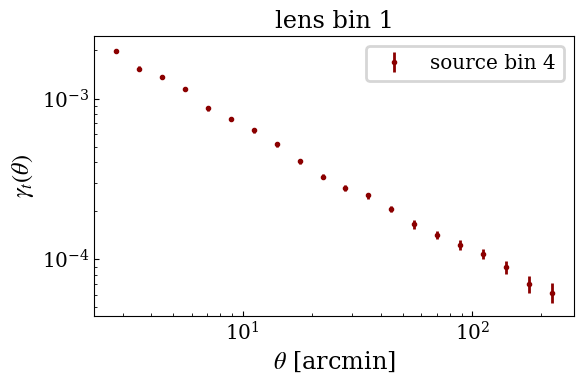

In [40]:
plot_gammat(theta, gammat_tot, err_gammat, l_zbin, s_zbin)
plt.show()

### Run it with your custom data selection

e.g. red/blue MagLim lenses

In [43]:
color_cuts = np.array([100,100,100,1.45,1.6,1.7]) # first 3 bins are all blue

def load_lens_Y3_maglim_redblue(file_name, zbin_lims, zbin, color_cuts, red=True):
    """Load ra, dec, weight of Y3 MagLim red/blue redshift bin zbin in [zbin_lims[0], zbin_lims[1]] from file"""
    
    with h5.File(file_name, 'r') as f:
        select_maglim = np.array(f['index/maglim/select'])
        ra = np.array(f['catalog/gold/ra'])[select_maglim]
        dec = np.array(f['catalog/gold/dec'])[select_maglim]
        z = np.array(f['catalog/dnf/unsheared/zmean_sof'])[select_maglim]
        mag_r = np.array(f['catalog/gold/sof_cm_mag_corrected_r'])[select_maglim]
        mag_z = np.array(f['catalog/gold/sof_cm_mag_corrected_z'])[select_maglim]
    
    ### Y3 maglim weights ?
    w = np.ones(len(ra))

    zbin_mask = np.where((z>zbin_lims[0]) * (z<zbin_lims[1]))[0]
    
    if red == True:
        red_mask = np.where(mag_r[zbin_mask]-mag_z[zbin_mask]>=color_cuts[zbin])[0]
    else: # select blue
        red_mask = np.where(mag_r[zbin_mask]-mag_z[zbin_mask]<color_cuts[zbin])[0]
    
    ra = ra[zbin_mask][red_mask]
    dec = dec[zbin_mask][red_mask]
    w = w[zbin_mask][red_mask]
    mag_r = mag_r[zbin_mask][red_mask]
    mag_z = mag_z[zbin_mask][red_mask]
        
    return ra, dec, w, mag_r, mag_z

In [44]:
mastercat = '/global/cfs/cdirs/des/www/y3_cats/Y3_mastercat_02_05_21.h5'
randoms_y3 = '/global/cfs/cdirs/des/y6-gglensing/Y3_maglim_randoms.fits'

l_zbin = 3
zl_lims = zl_bins[l_zbin]
s_zbin = 3
print('Lens bin {:d}, source bin {:d}'.format(l_zbin, s_zbin))
            
# load lenses maglim Y3 red  
ra_l, dec_l, w_l, mag_r, mag_z = load_lens_Y3_maglim_redblue(mastercat, zl_lims, l_zbin, color_cuts, red=True)
print('Num lenses = {:d}'.format(len(ra_l)))

# load sources metacal Y3
ra_s, dec_s, e1, e2, R, w_s = setup.load_source_metacal(mastercat, s_zbin)
print('Num sources = {:d}'.format(len(ra_s)))
print('Average e1 = {:f}'.format(np.average(e1, weights=w_s)))
print('Average e2 = {:f}'.format(np.average(e2, weights=w_s)))

# load random points Y3
ra_r, dec_r = setup.load_randoms_Y3(randoms_y3, zl_lims)
print('Num randoms = {:d}'.format(len(ra_r)))

Lens bin 3, source bin 3
Num lenses = 1005013
Num sources = 25091297
Average e1 = 0.000406
Average e2 = -0.000027
Num randoms = 86645516


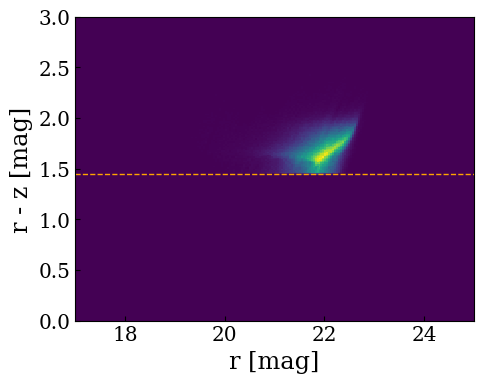

In [60]:
fig = plt.figure(figsize=(5, 4))

plt.hist2d(mag_r, mag_r-mag_z, bins=200, range=([17,25],[0,3]))
plt.hlines(color_cuts[l_zbin], 17, 25, color='orange', ls='--', lw=1)
plt.xlabel('r [mag]')
plt.ylabel('r - z [mag]')

plt.tight_layout()
fig.patch.set_alpha(1.0)
plt.show()

In [51]:
theta_lims = [0.25, 250.]
ang_nbins = 30
sep_units = 'arcmin'
bin_slop = 0.0
low_mem = False
npatch = 200

use_randoms = True
use_boost = True
compute_cov = True

(theta, gammat, gammax, gammat_shot_noise, xi_npairs, xi_weight,
gammat_tot, gammax_tot, boost,
gammat_rand, gammax_rand, xi_npairs_rand, xi_weight_rand,
cov_gammat, cov_gammax, cov_boost, cov_gammat_rand) = ggl.get_ggl(ra_l, dec_l, w_l, ra_s, dec_s, w_s, 
                                                                  e1, e2, R, ra_r, dec_r, 'deg',
                                                                  theta_lims, ang_nbins, sep_units, bin_slop, low_mem, 
                                                                  use_randoms, use_boost, compute_cov, npatch, 
                                                                  ggl_file_out='', cov_file_out='')

Running GGL ...
Done NG
Done RG
Not saving GGL results to file
Done Covariance
Not saving covariances to file


In [52]:
err_gammat = np.sqrt(np.diag(cov_gammat))

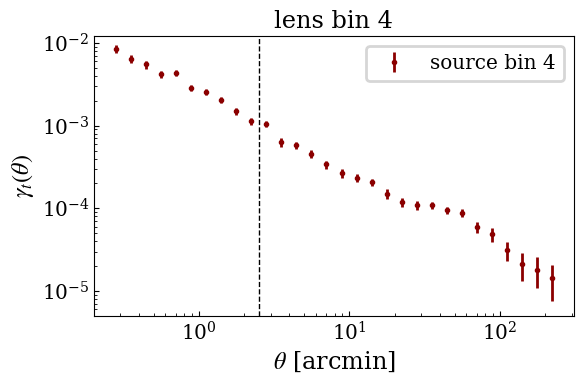

In [59]:
plot_gammat(theta, gammat_tot, err_gammat, l_zbin, s_zbin)
plt.vlines(2.5, 5e-6, 1.2e-2, lw=1, ls='--')
plt.ylim(5e-6, 1.2e-2)
plt.show()